# NICE for calibration: Comparison against other methods 

In [1]:
import os
import sys
sys.path.append('..')

import numpy as np
import tensorflow as tf
from scipy.special import softmax
import matplotlib.pyplot as plt

from utils.data import get_cifar10, get_cifar3, load_logits
from utils.ops import onehot_encode
from utils.metrics import neg_log_likelihood, expected_calibration_error
from utils.visualization import plot_pdf_simplex, plot_prob_simplex, reliability_diagram
from calibrators import NiceCalibrator, TempScalingCalibrator

In [2]:
%matplotlib inline

### Load cifar10

In [3]:
cifar_dir = '../cifar-10'

In [4]:
cifar10, ix2label = get_cifar10(cifar_dir, test=True)

To compare the calibration capabilities of each method we are going to calibrate the model on a subset of the test set, and evaluate it on the other subset. Then compare results for each calibration method.

In [5]:
target = onehot_encode(cifar10['test_labels'])

# val/test split
random_split = np.random.permutation(10000)

val_target = target[random_split[:5000], :]
test_target = target[random_split[5000:], :]

### Load precomputed logits

In [6]:
model = 'resnet32_v1'
models_dir = '../pretrained-models'

In [7]:
_, logits = load_logits(os.path.join(models_dir, model))

# val/test split
val_logits = logits[random_split[:5000], :]
test_logits = logits[random_split[5000:], :]

## Calibrating the model

### Evaluating the uncalibrated model:
Negative Log-Likelihood and Expected Calibration Error on validation and test set

In [8]:
val_probs = softmax(val_logits, axis=1)
test_probs = softmax(test_logits, axis=1)

# Validation set
val_nll = neg_log_likelihood(val_probs, val_target)
val_ece = expected_calibration_error(val_probs, val_target, bins=15)

print('Negative log-likelihood of the uncalibrated model on the validation set: {:.3f}'.format(val_nll))
print('Expected calibration error of the uncalibrated model on the validation set: {:.5f}'.format(val_ece))

print('\n')

# Test set
test_nll = neg_log_likelihood(test_probs, test_target)
test_ece = expected_calibration_error(test_probs, test_target, bins=15)

print('Negative log-likelihood of the uncalibrated model on the test set: {:.3f}'.format(test_nll))
print('Expected calibration error of the uncalibrated model on the test set: {:.5f}'.format(test_ece))

Negative log-likelihood of the uncalibrated model on the validation set: 0.260
Expected calibration error of the uncalibrated model on the validation set: 0.03561


Negative log-likelihood of the uncalibrated model on the test set: 0.275
Expected calibration error of the uncalibrated model on the test set: 0.03489


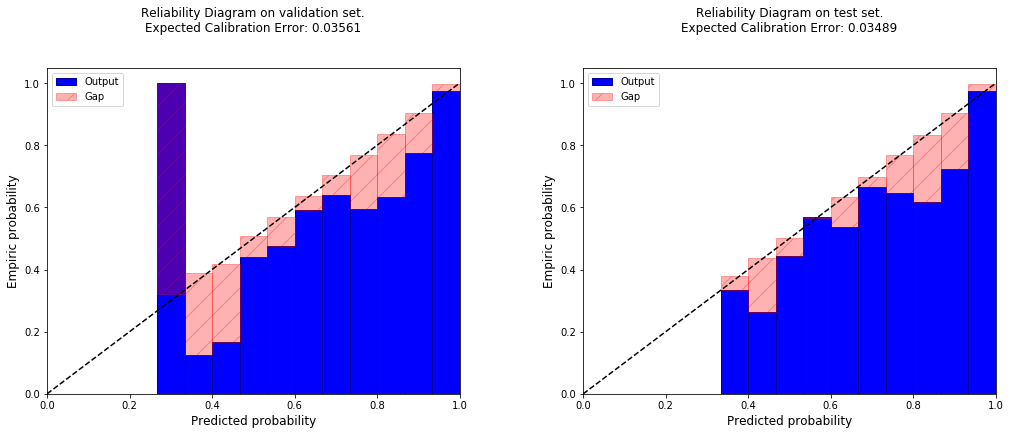

In [9]:
fig, ax_arr = plt.subplots(1, 2, figsize=(17, 6), gridspec_kw={'hspace': 0.3, 'wspace': 0.3})

ax_arr[0] = reliability_diagram(val_probs, val_target, ax=ax_arr[0], title='Reliability Diagram on validation set.'+
                                '\nExpected Calibration Error: {:.5f}'.format(val_ece), bins=15)
ax_arr[1] = reliability_diagram(test_probs, test_target, ax=ax_arr[1], title='Reliability Diagram on test set.' + 
                                '\nExpected Calibration Error: {:.5f}'.format(test_ece), bins=15)
plt.show()

### Temperature Scaling calibration:

In [10]:
temp_scaling_cal = TempScalingCalibrator(val_logits, val_target)
print("Calibrated using temperature T={:.3f}".format(temp_scaling_cal.T))

Calibrated using temperature T=1.742


Evaluating calibration:

In [11]:
val_probs_temp = temp_scaling_cal.predict(val_logits)
test_probs_temp = temp_scaling_cal.predict(test_logits)

# Validation set
val_nll_temp = neg_log_likelihood(val_probs_temp, val_target)
val_ece_temp = expected_calibration_error(val_probs_temp, val_target, bins=15)

print('Negative log-likelihood on the validation set after temp-scaling calibration: {:.3f}'.format(val_nll_temp))
print('Expected calibration error on the validation set after temp-scaling calibration: {:.5f}'.format(val_ece_temp))

print('\n')

# Test set
test_nll_temp = neg_log_likelihood(test_probs_temp, test_target)
test_ece_temp = expected_calibration_error(test_probs_temp, test_target, bins=15)

print('Negative log-likelihood on the test set after temp-scaling calibration: {:.3f}'.format(test_nll_temp))
print('Expected calibration error on the test set after temp-scaling calibration: {:.5f}'.format(test_ece_temp))

Negative log-likelihood on the validation set after temp-scaling calibration: 0.215
Expected calibration error on the validation set after temp-scaling calibration: 0.00526


Negative log-likelihood on the test set after temp-scaling calibration: 0.227
Expected calibration error on the test set after temp-scaling calibration: 0.00784


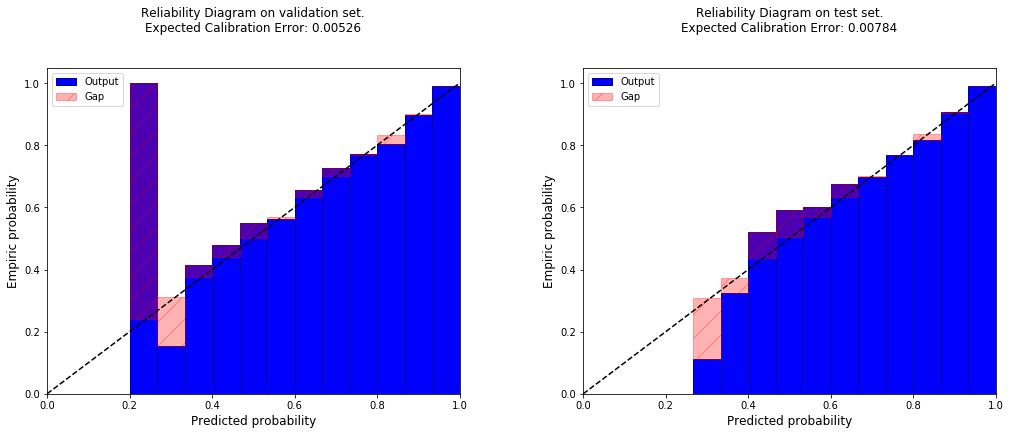

In [12]:
fig, ax_arr = plt.subplots(1, 2, figsize=(17, 6), gridspec_kw={'hspace': 0.3, 'wspace': 0.3})

ax_arr[0] = reliability_diagram(val_probs_temp, val_target, ax=ax_arr[0], title='Reliability Diagram on validation set.'+
                                '\nExpected Calibration Error: {:.5f}'.format(val_ece_temp), bins=15)
ax_arr[1] = reliability_diagram(test_probs_temp, test_target, ax=ax_arr[1], title='Reliability Diagram on test set.' + 
                                '\nExpected Calibration Error: {:.5f}'.format(test_ece_temp), bins=15)
plt.show()

### NICE flow calibration:

In [13]:
nice_cal = NiceCalibrator(val_logits, val_target, layers=4, hidden_size=[10, 10])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


C:\Users\sergi\Anaconda3\envs\famarch\lib\site-packages\tensorflow\python\ops\gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Evaluating calibration:

In [14]:
val_probs_nice = nice_cal.predict(val_logits)
test_probs_nice = nice_cal.predict(test_logits)

# Validation set
val_nll_nice = neg_log_likelihood(val_probs_nice, val_target)
val_ece_nice = expected_calibration_error(val_probs_nice, val_target, bins=15)

print('Negative log-likelihood on the validation set after NICE calibration: {:.3f}'.format(val_nll_nice))
print('Expected calibration error on the validation set after NICE calibration: {:.5f}'.format(val_ece_nice))

print('\n')

# Test set
test_nll_nice = neg_log_likelihood(test_probs_nice, test_target)
test_ece_nice = expected_calibration_error(test_probs_nice, test_target, bins=15)

print('Negative log-likelihood on the test set after NICE calibration: {:.3f}'.format(test_nll_nice))
print('Expected calibration error on the test set after NICE calibration: {:.5f}'.format(test_ece_nice))

Negative log-likelihood on the validation set after NICE calibration: 0.080
Expected calibration error on the validation set after NICE calibration: 0.01838


Negative log-likelihood on the test set after NICE calibration: 0.498
Expected calibration error on the test set after NICE calibration: 0.06310


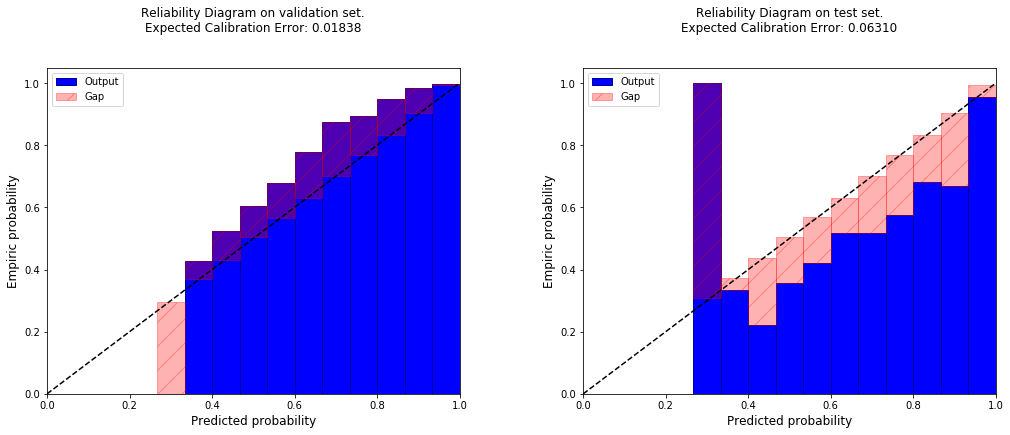

In [15]:
fig, ax_arr = plt.subplots(1, 2, figsize=(17, 6), gridspec_kw={'hspace': 0.3, 'wspace': 0.3})

ax_arr[0] = reliability_diagram(val_probs_nice, val_target, ax=ax_arr[0], title='Reliability Diagram on validation set.'+
                                '\nExpected Calibration Error: {:.5f}'.format(val_ece_nice), bins=15)
ax_arr[1] = reliability_diagram(test_probs_nice, test_target, ax=ax_arr[1], title='Reliability Diagram on test set.' + 
                                '\nExpected Calibration Error: {:.5f}'.format(test_ece_nice), bins=15)

plt.show()

## CIFAR3

In [16]:
cifar3, ix2label = get_cifar3(cifar_dir, test=True)

target = onehot_encode(cifar3['test_labels'])

# val/test split
random_split = np.random.permutation(3000)

val_target = target[random_split[:1500], :]
test_target = target[random_split[1500:], :]

In [26]:
models_dir = '../pretrained-models'
model = 'cnn_cifar3'
_, logits = load_logits(os.path.join(models_dir, model))

# val/test split
val_logits = logits[random_split[:1500], :]
test_logits = logits[random_split[1500:], :]

### Uncalibrated model: 

In [27]:
val_probs = softmax(val_logits, axis=1)
test_probs = softmax(test_logits, axis=1)

# Validation set
val_nll = neg_log_likelihood(val_probs, val_target)
val_ece = expected_calibration_error(val_probs, val_target, bins=15)

print('Negative log-likelihood of the uncalibrated model on the validation set: {:.3f}'.format(val_nll))
print('Expected calibration error of the uncalibrated model on the validation set: {:.5f}'.format(val_ece))

print('\n')

# Test set
test_nll = neg_log_likelihood(test_probs, test_target)
test_ece = expected_calibration_error(test_probs, test_target, bins=15)

print('Negative log-likelihood of the uncalibrated model on the test set: {:.3f}'.format(test_nll))
print('Expected calibration error of the uncalibrated model on the test set: {:.5f}'.format(test_ece))

Negative log-likelihood of the uncalibrated model on the validation set: 0.329
Expected calibration error of the uncalibrated model on the validation set: 0.03121


Negative log-likelihood of the uncalibrated model on the test set: 0.317
Expected calibration error of the uncalibrated model on the test set: 0.02234


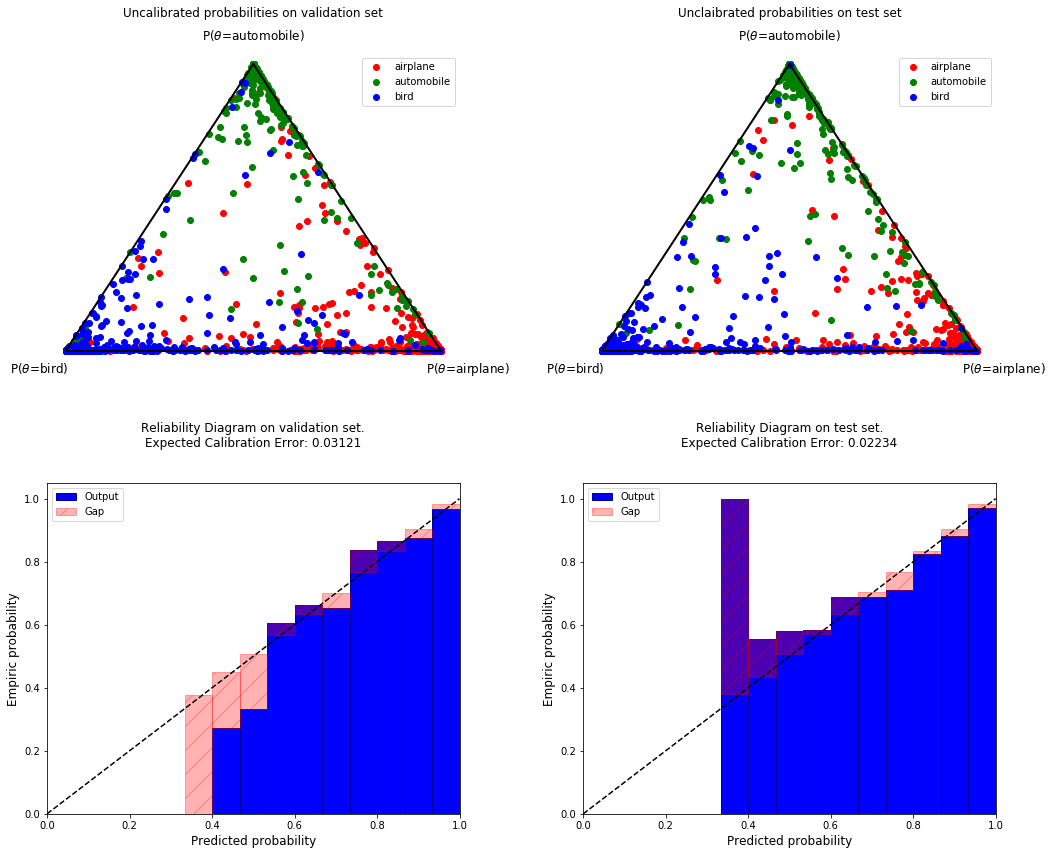

In [28]:
fig, ax_arr = plt.subplots(2, 2, figsize=(17, 14), gridspec_kw={'hspace': 0.3, 'wspace': 0.3})
ax_arr[0, 0] = plot_prob_simplex(val_probs, target=val_target, ax=ax_arr[0, 0],
                              title='Uncalibrated probabilities on validation set', fontsize=12, labels=list(ix2label.values()));
ax_arr[0, 1] = plot_prob_simplex(test_probs, target=test_target, ax=ax_arr[0, 1],
                              title='Unclaibrated probabilities on test set', fontsize=12, labels=list(ix2label.values()));

ax_arr[1, 0] = reliability_diagram(val_probs, val_target, ax=ax_arr[1, 0], title='Reliability Diagram on validation set.'+
                                '\nExpected Calibration Error: {:.5f}'.format(val_ece), bins=15)
ax_arr[1, 1] = reliability_diagram(test_probs, test_target, ax=ax_arr[1, 1], title='Reliability Diagram on test set.' + 
                                '\nExpected Calibration Error: {:.5f}'.format(test_ece), bins=15)

plt.show()

### Temperature scaling:

In [29]:
temp_scaling_cal = TempScalingCalibrator(val_logits, val_target)
print("Calibrated using temperature T={:.3f}".format(temp_scaling_cal.T))

Calibrated using temperature T=1.131


In [30]:
val_probs_temp = temp_scaling_cal.predict(val_logits)
test_probs_temp = temp_scaling_cal.predict(test_logits)

# Validation set
val_nll_temp = neg_log_likelihood(val_probs_temp, val_target)
val_ece_temp = expected_calibration_error(val_probs_temp, val_target, bins=15)

print('Negative log-likelihood on the validation set after temp-scaling calibration: {:.3f}'.format(val_nll_temp))
print('Expected calibration error on the validation set after temp-scaling calibration: {:.5f}'.format(val_ece_temp))

print('\n')

# Test set
test_nll_temp = neg_log_likelihood(test_probs_temp, test_target)
test_ece_temp = expected_calibration_error(test_probs_temp, test_target, bins=15)

print('Negative log-likelihood on the test set after temp-scaling calibration: {:.3f}'.format(test_nll_temp))
print('Expected calibration error on the test set after temp-scaling calibration: {:.5f}'.format(test_ece_temp))

Negative log-likelihood on the validation set after temp-scaling calibration: 0.326
Expected calibration error on the validation set after temp-scaling calibration: 0.02087


Negative log-likelihood on the test set after temp-scaling calibration: 0.314
Expected calibration error on the test set after temp-scaling calibration: 0.02372


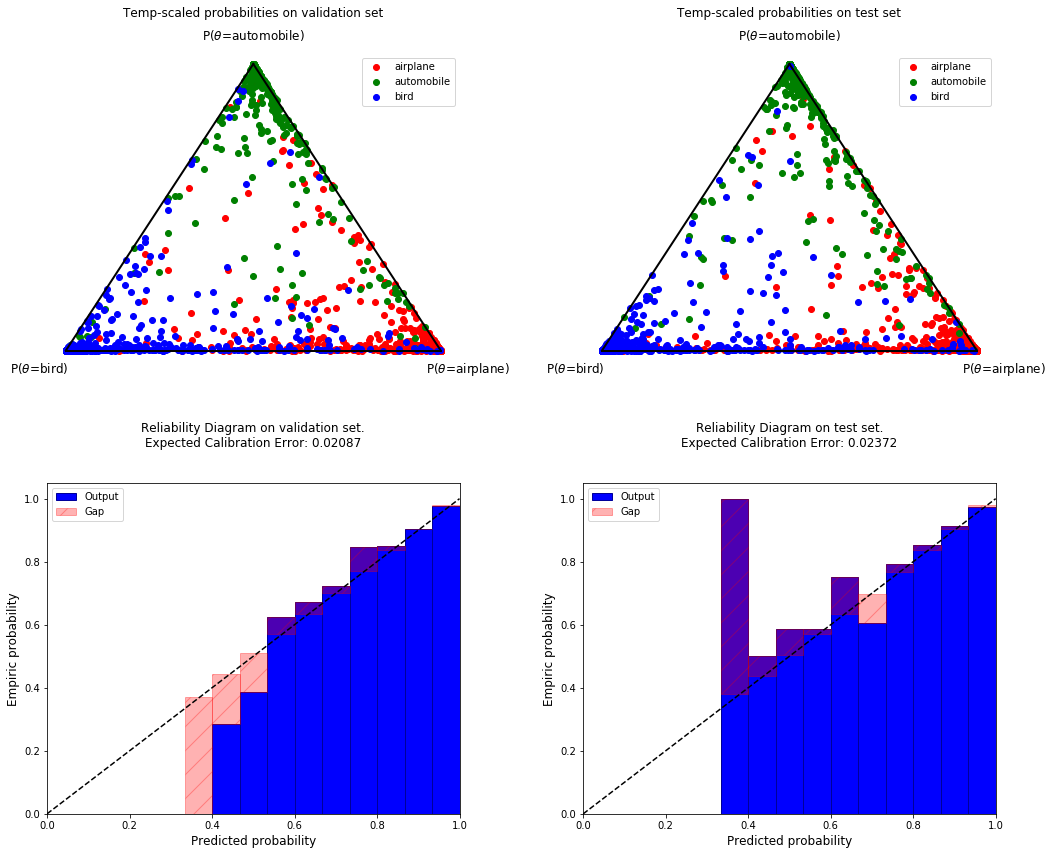

In [31]:
fig, ax_arr = plt.subplots(2, 2, figsize=(17, 14), gridspec_kw={'hspace': 0.3, 'wspace': 0.3})
ax_arr[0, 0] = plot_prob_simplex(val_probs_temp, target=val_target, ax=ax_arr[0, 0],
                              title='Temp-scaled probabilities on validation set', fontsize=12, labels=list(ix2label.values()));
ax_arr[0, 1] = plot_prob_simplex(test_probs_temp, target=test_target, ax=ax_arr[0, 1],
                              title='Temp-scaled probabilities on test set', fontsize=12, labels=list(ix2label.values()));

ax_arr[1, 0] = reliability_diagram(val_probs_temp, val_target, ax=ax_arr[1, 0], title='Reliability Diagram on validation set.'+
                                '\nExpected Calibration Error: {:.5f}'.format(val_ece_temp), bins=15)
ax_arr[1, 1] = reliability_diagram(test_probs_temp, test_target, ax=ax_arr[1, 1], title='Reliability Diagram on test set.' + 
                                '\nExpected Calibration Error: {:.5f}'.format(test_ece_temp), bins=15)
plt.show()

### NICE flow calibration: 

In [32]:
nice_cal = NiceCalibrator(val_logits, val_target, layers=4, hidden_size=[4, 4], version=2)

C:\Users\sergi\Anaconda3\envs\famarch\lib\site-packages\tensorflow\python\ops\gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [33]:
val_probs_nice = nice_cal.predict(val_logits)
test_probs_nice = nice_cal.predict(test_logits)

# Validation set
val_nll_nice = neg_log_likelihood(val_probs_nice, val_target)
val_ece_nice = expected_calibration_error(val_probs_nice, val_target, bins=15)

print('Negative log-likelihood on the validation set after NICE calibration: {:.3f}'.format(val_nll_nice))
print('Expected calibration error on the validation set after NICE calibration: {:.5f}'.format(val_ece_nice))

print('\n')

# Test set
test_nll_nice = neg_log_likelihood(test_probs_nice, test_target)
test_ece_nice = expected_calibration_error(test_probs_nice, test_target, bins=15)

print('Negative log-likelihood on the test set after NICE calibration: {:.3f}'.format(test_nll_nice))
print('Expected calibration error on the test set after NICE calibration: {:.5f}'.format(test_ece_nice))

Negative log-likelihood on the validation set after NICE calibration: 0.296
Expected calibration error on the validation set after NICE calibration: 0.01833


Negative log-likelihood on the test set after NICE calibration: 0.324
Expected calibration error on the test set after NICE calibration: 0.02376


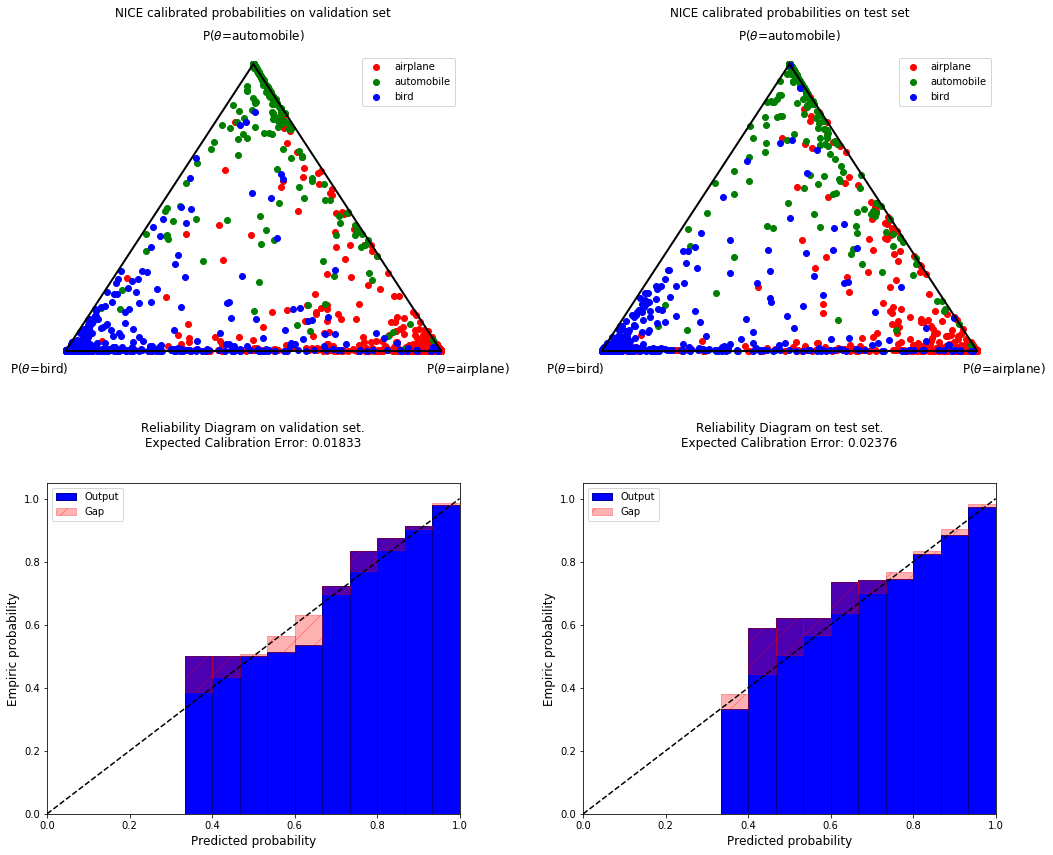

In [34]:
fig, ax_arr = plt.subplots(2, 2, figsize=(17, 14), gridspec_kw={'hspace': 0.3, 'wspace': 0.3})
ax_arr[0, 0] = plot_prob_simplex(val_probs_nice, target=val_target, ax=ax_arr[0, 0],
                              title='NICE calibrated probabilities on validation set', fontsize=12, labels=list(ix2label.values()));
ax_arr[0, 1] = plot_prob_simplex(test_probs_nice, target=test_target, ax=ax_arr[0, 1],
                              title='NICE calibrated probabilities on test set', fontsize=12, labels=list(ix2label.values()));

ax_arr[1, 0] = reliability_diagram(val_probs_nice, val_target, ax=ax_arr[1, 0], title='Reliability Diagram on validation set.'+
                                '\nExpected Calibration Error: {:.5f}'.format(val_ece_nice), bins=15)
ax_arr[1, 1] = reliability_diagram(test_probs_nice, test_target, ax=ax_arr[1, 1], title='Reliability Diagram on test set.' + 
                                '\nExpected Calibration Error: {:.5f}'.format(test_ece_nice), bins=15)
plt.show()